Team Name :- Hackenatics

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
folder = "/content/drive/MyDrive/DataSprint/1"

train_df = pd.read_csv(folder + "/train.csv")
test_df = pd.read_csv(folder + "/test.csv")
sample_df = pd.read_csv(folder + "/sample_submission.csv")


In [ ]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,11.856445
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,9.803672
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485500,12.465738
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,9.836608
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,1.098944,8.930470


Data Cleaning


In [ ]:
# Cleaning the dataframe where trip duration in negaitve
train_df = train_df[train_df['trip_duration'] > 0]



In [ ]:
pip install haversine

In [ ]:
# This line is filtering out unrealistic trips like 100 meters trip and where trip duration is more than 10 minutes
from haversine import haversine

train_df['distance'] = train_df.apply(lambda r:
                                haversine((r['pickup_latitude'], r['pickup_longitude']),
                                          (r['dropoff_latitude'], r['dropoff_longitude'])), axis=1)


train_df = train_df[~((train_df['distance'] < 0.1) & (train_df['trip_duration'] > 600))]


In [ ]:
#this line will create a column in dataframe which will show the speed
train_df['speed_kmh'] = (train_df['distance'] / (train_df['trip_duration'] / 3600))


In [ ]:
# This line is used to clean dataframe where speed is more than 80kmph
train_df = train_df[train_df['speed_kmh'] < 80]


In [ ]:
#Removes outlier trip durations(trips that are too short or too long compared to normal rides).
Q1 = train_df['trip_duration'].quantile(0.25)
Q3 = train_df['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

train_df = train_df[(train_df['trip_duration'] >= lower_limit) &
              (train_df['trip_duration'] <= upper_limit)]


In [ ]:
#Removes trips outside NYC boundaries(wrong GPS data, unrealistic coordinates).
train_df = train_df[
    (train_df['pickup_latitude'].between(40.5, 41.0)) &
    (train_df['dropoff_latitude'].between(40.5, 41.0)) &
    (train_df['pickup_longitude'].between(-74.3, -73.6)) &
    (train_df['dropoff_longitude'].between(-74.3, -73.6))
]


Feature Engineering


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
coords = np.vstack((train_df[['pickup_latitude', 'pickup_longitude']].values,
                    train_df[['dropoff_latitude', 'dropoff_longitude']].values))


In [ ]:
# using KMeansClustering to create cluster of different locaations in newyork city
k = 30
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(coords)


KMeans(n_clusters=30, random_state=42)

In [ ]:
# This code will create pickup and dropoff cluster for our datframe by the lattitude and longitude given
train_df['pickup_cluster'] = kmeans.predict(train_df[['pickup_latitude', 'pickup_longitude']])
train_df['dropoff_cluster'] = kmeans.predict(train_df[['dropoff_latitude', 'dropoff_longitude']])

test_df['pickup_cluster'] = kmeans.predict(test_df[['pickup_latitude', 'pickup_longitude']])
test_df['dropoff_cluster'] = kmeans.predict(test_df[['dropoff_latitude', 'dropoff_longitude']])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


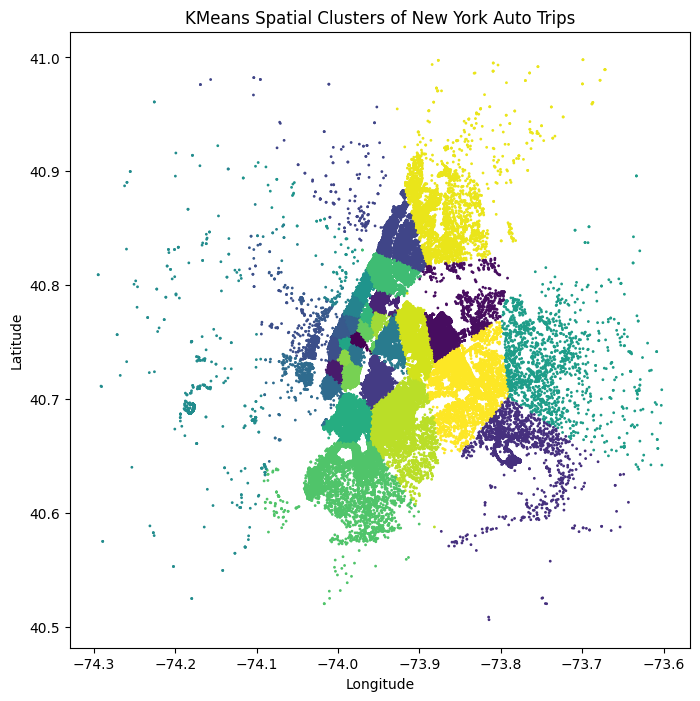

In [ ]:
# This is the visual representations of the cluster created by our dataframe which will helps to identify about the traffic in different locations of the city
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(coords[:,1], coords[:,0], c=kmeans.labels_, s=1, cmap='viridis')
plt.title("KMeans Spatial Clusters of New York Auto Trips")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
 This code is used to convert pickup_datetime into hour, day , weekday etc in both test and train dataframe format to keep track of time at which the ride is booked
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])

train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_day'] = train_df['pickup_datetime'].dt.day
train_df['pickup_weekday'] = train_df['pickup_datetime'].dt.weekday
train_df['pickup_month'] = train_df['pickup_datetime'].dt.month
train_df['pickup_year'] = train_df['pickup_datetime'].dt.year
train_df['is_weekend'] = (train_df['pickup_weekday'] >= 5).astype(int)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])

test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour
test_df['pickup_day'] = test_df['pickup_datetime'].dt.day
test_df['pickup_weekday'] = test_df['pickup_datetime'].dt.weekday
test_df['pickup_month'] = test_df['pickup_datetime'].dt.month
test_df['pickup_year'] = test_df['pickup_datetime'].dt.year
test_df['is_weekend'] = (test_df['pickup_weekday'] >= 5).astype(int)



In [ ]:
# this is the functioning of haversine function or we can just import the library. Def:-Haversine distance calculates the real-world distance
#between two latitude–longitude points on Earth by considering the planet’s curvature. It gives an accurate “as-the-crow-flies” distance in kilometers.
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


In [ ]:
# this code will add another feature into our model which will keep track of the haversine distance in train dataframe
train_df['haversine_distance'] = haversine(
    train_df['pickup_latitude'], train_df['pickup_longitude'],
    train_df['dropoff_latitude'], train_df['dropoff_longitude']
)


In [ ]:
## this code will add another feature into our model which will keep track of the haversine distance in test dataframe
test_df['haversine_distance'] = haversine(
    test_df['pickup_latitude'], test_df['pickup_longitude'],
    test_df['dropoff_latitude'], test_df['dropoff_longitude']
)


In [ ]:
# This code will add another feature in the model which is manhattan distance which meansManhattan distance
#measures the distance between two points by moving only along horizontal and vertical paths
#(like city blocks). It adds the absolute differences of x and y coordinates instead of using a straight-line path
train_df['manhattan_distance'] = (
    abs(train_df['dropoff_longitude'] - train_df['pickup_longitude']) +
    abs(train_df['dropoff_latitude'] - train_df['pickup_latitude'])
)

test_df['manhattan_distance'] = (
    abs(test_df['dropoff_longitude'] - test_df['pickup_longitude']) +
    abs(test_df['dropoff_latitude'] - test_df['pickup_latitude'])
)


In [ ]:
# Separate target first
y = train_df['trip_duration']

# Columns to drop from train
drop_cols_train = [

    'pickup_datetime',
    'dropoff_datetime'

]

# Remove them
train_df = train_df.drop(columns=drop_cols_train, errors='ignore')


In [ ]:
drop_cols_test = [

    'pickup_datetime'
]

test_df = test_df.drop(columns=drop_cols_test, errors='ignore')


In [ ]:
print(train_df.columns)
print(test_df.columns)


Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'distance', 'speed_kmh',
       'pickup_cluster', 'dropoff_cluster', 'pickup_hour', 'pickup_day',
       'pickup_weekday', 'pickup_month', 'pickup_year', 'is_weekend',
       'haversine_distance', 'manhattan_distance'],
      dtype='object')
Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_day', 'pickup_weekday',
       'pickup_month', 'pickup_year', 'is_weekend', 'haversine_distance',
       'manhattan_distance', 'pickup_cluster', 'dropoff_cluster'],
      dtype='object')


In [ ]:
#is code safely removes the distance and speed_kmh columns from the dataframe to avoid data leakage
train_df = train_df.drop(columns=['distance', 'speed_kmh'], errors='ignore')


In [ ]:
# It converts a categorical column (store_and_fwd_flag) into numerical values
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})
test_df['store_and_fwd_flag'] = test_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})


**Explaining feature engineering of the model**

pickup_cluster / dropoff_cluster – Cluster IDs that group nearby locations together to capture spatial patterns in the city.

pickup_hour / pickup_day / pickup_weekday / pickup_month / pickup_year – Time-based features that help the model learn trends such as rush hours, weekends, and seasonal effects.

is_weekend – Indicates whether the trip occurred on a weekend (higher traffic patterns).

haversine_distance – Straight-line distance between pickup and dropoff points using Earth’s curvature.

manhattan_distance – Grid-based distance approximating NYC street layouts for more realistic movement.

In [ ]:
# These are the final features which we are using to create our ML model
final_features = [
    'vendor_id',
    'passenger_count',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'store_and_fwd_flag',
    'pickup_cluster',
    'dropoff_cluster',
    'pickup_hour',
    'pickup_day',
    'pickup_weekday',
    'pickup_month',
    'pickup_year',
    'is_weekend',
    'haversine_distance',
    'manhattan_distance'
]

# For train
X = train_df[final_features]
y = train_df['trip_duration']



Model creation


In [ ]:


# Splitting training dataframe into X_train and X_valid to check the accuracy of model
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42     # ensures repeatable split
)



In [ ]:
!pip install lightgbm


In [ ]:
# We are using LightGBM Regressor because it handles large datasets efficiently and learns complex patterns quickly.
#It also performs better than most traditional models without needing heavy feature engineering or long training time.
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import mean_squared_log_error

lgb_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=64,
    n_estimators=500,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse'
)

# Predict
y_pred = lgb_model.predict(X_valid)
y_pred = np.maximum(y_pred, 0)

# Evaluate
rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
print("Validation RMSLE:", rmsle)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.302398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1674
[LightGBM] [Info] Number of data points in

Model Evaluation

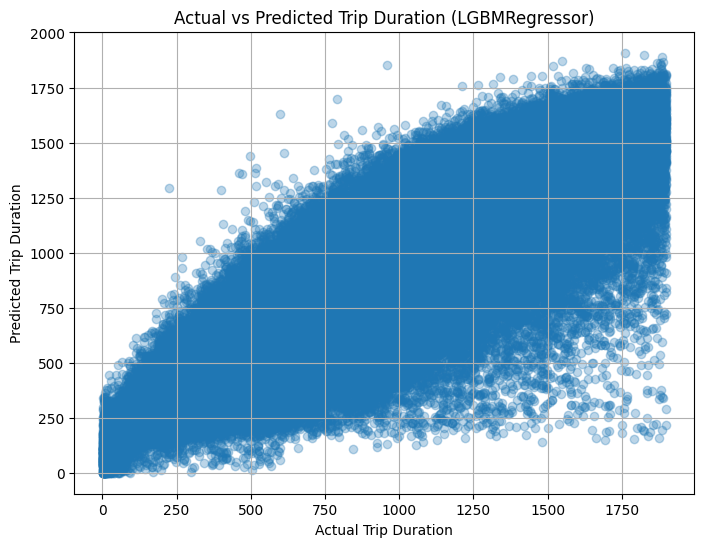

In [ ]:
# This is the plot of actual versus predicted duration of the model
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Duration")
plt.ylabel("Predicted Trip Duration")
plt.title("Actual vs Predicted Trip Duration (LGBMRegressor)")
plt.grid(True)
plt.show()


Model Predictions

In [ ]:
# Now testing our model on the test dataframe
# 1. taking the same features from test as we used in train dataframe
test_X = test_df[final_features]

# 2. Convert to numeric
test_X = test_X.apply(pd.to_numeric, errors='coerce').fillna(0)

# 3. Predicting the model
test_pred = lgb_model.predict(test_X)

# 4. Fix negative values (LightGBM rarely produces negative)
test_pred = np.maximum(test_pred, 0)

# 5. Building  submission df
submission = pd.DataFrame({
    'id': test_df['id'],
    'trip_duration': test_pred
})

# 6. converting submission dataframe into csv file as mentioned
submission.to_csv("submission.csv", index=False)

submission.head()


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


,id,trip_duration
0,id3004672,886.722246
1,id3505355,669.790271
2,id1217141,451.902111
3,id2150126,1008.700114
4,id1598245,350.748861
